<a href="https://colab.research.google.com/github/enVives/Caltech101/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from itertools import filterfalse
from collections import OrderedDict
!pip install ultralytics
from ultralytics import YOLO
import torch,torchvision
import numpy as np
import pandas as pd
import math
import cv2
import time
import os
import wandb
import shutil
import pylab as pl
import scipy.io
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from torchvision import transforms,models
from torch import nn
from IPython.display import clear_output,display
from torch.utils.data import DataLoader, random_split,Subset,Dataset
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from glob import glob

ROOT = './sample_data/'
CLASS_A = 'cougar_body'
CLASS_B = 'windsor_chair'

DOWNLOAD = True
DUPLICAR_DADES = True
wandb.login()
#471be466c8949671a46c67e7aad0d5a0ac8c9dad
!rm -rf /content/sample_data/*


# !rm -rf /content/dataset/images/*
# !rm -rf /content/dataset/labels/*/*
# torch.cuda.default_stream(torch.device('cuda'))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 23.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
def find_mean_std(dataset):
  dataloader = DataLoader(dataset,batch_size = 1,shuffle=FALSE)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  samples = 0

  for image,_ in dataloader:
    mean += image.mean(dim=[0, 2, 3])  # Mean for each channel [batchsize,channels,height,width]
    std += image.std(dim=[0, 2, 3])    # Std for each channel
    samples += 1

  mean /= samples
  std /= samples

  print(mean)
  print(std)

In [3]:
from pickle import NONE

class Formes(Dataset):
    def __init__(self, paths, labels= None, transforms = None,annotations = None,transform_mask = None):
        self.images = paths
        self.labels = labels
        self.transforms = transforms
        self.annotations = annotations
        self.transforms_mask = transform_mask

    def __len__(self):
        return len(self.labels)

    def __setmodel__(self,model):
        self.model = model

    def __getdist__(self):
      return pd.Series(self.labels).value_counts()

    def __showcontours__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      plt.imshow(image)

      mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

      polygons_data = mat_data['obj_contour']

      x_points = polygons_data[0]
      y_points = polygons_data[1]

      contour_points = np.array(list(zip(x_points,y_points)))

      plt.plot(contour_points[:, 0], contour_points[:, 1], '-r')  # Red contour line
      plt.scatter(contour_points[:, 0], contour_points[:, 1], c='blue')  # Optional: Mark contour points
      plt.show()

    def __getpureimage__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      return image

    def __getitem__(self, index):
      path = self.images[index]
      label = self.labels[index]

      seed = torch.random.seed()  # Create a unique seed for random operations

      if self.annotations != None:
        mat_data = scipy.io.loadmat(self.annotations[index])


        polygons_data = mat_data['obj_contour']
        boundingbox_data = mat_data['box_coord']

        # print("Keys in MAT file:", mat_data.keys())

        x_points = polygons_data[0]
        y_points = polygons_data[1]

        contour_points = list(zip(x_points,y_points))
        contour = np.array(contour_points, dtype=np.int32)

        #print(contour_points)


      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if self.model == 3:
        mask = np.zeros(image.size, dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=255)  # White filled polygon
        mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image

        torch.random.manual_seed(seed)  # Set seed for image
        mask_resized = self.transforms_mask(mask)
        mask_resized = (mask_resized > 0.5).float()

        torch.random.manual_seed(seed)  # Set seed for image
        image = self.transforms(image)

        return image, mask_resized

      image = self.transforms(image)

      return image, label

In [4]:
def get_labels(sett):
  labels = np.array([])
  frequency = np.zeros(101)
  for _,label in sett:
    labels = np.append(labels,label)
    frequency[label] += 1
  return labels.astype(int),frequency

In [5]:
def escriu_informacio_yolo(carpeta,nom_imatge,annotations,class_id,image_size):

    label_file = os.path.join(carpeta, f"{os.path.splitext(nom_imatge)[0]}.txt")
    with open(label_file, "w") as f:
            y_min, y_max, x_min, x_max = annotations[0]

            if x_max > image_size[0]:
              x_max = image_size[0]
            if y_max > image_size[1]:
              y_max = image_size[1]

            if image_size:
                img_width, img_height = image_size
                x_center = ((x_min + x_max) / 2) / img_width
                y_center = ((y_min + y_max) / 2) / img_height
                width = (x_max - x_min) / img_width
                height = (y_max - y_min) / img_height
            else:
                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2
                width = x_max - x_min
                height = y_max - y_min

            # Escribe en el archivo
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [6]:
from re import X
#from pickle import FALSE
from sklearn.model_selection import train_test_split

TRAINING = 0.80
VAL = 0.10
TESTING = 0.10

#[0.5459, 0.5288, 0.5022]
#[0.2424, 0.2393, 0.2409]
mean = torch.tensor([0.485,0.456,0.406])
std = torch.tensor([0.229,0.224,0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_masks = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
])


transform2 = transforms.Compose([
    #transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Ensure all images are RGB
    transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(p=0.1),
    # transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.Caltech101(root= ROOT,download=DOWNLOAD,transform=transform)

img_class_1 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/cougar_body/*'))
img_class_2 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/windsor_chair/*'))

img_annotations_class_1 = sorted(glob('/content/sample_data/caltech101/Annotations/cougar_body/*'))
img_annotations_class_2 = sorted(glob('/content/sample_data/caltech101/Annotations/windsor_chair/*'))


img_files = img_class_1 +  img_class_2
img_annotations = img_annotations_class_1 + img_annotations_class_2

if DUPLICAR_DADES:
  img_files_duplicated = img_files + img_files  # Duplicate image paths
  img_annotations_duplicated = img_annotations + img_annotations  # Duplicate annotation paths

  img_files = img_files_duplicated
  img_annotations = img_annotations_duplicated

labels = []
for img_path in img_files:
  label = img_path.split(os.path.sep)[-2]
  labels.append(label)

lb = LabelEncoder()
labels = lb.fit_transform(labels)

weights = 1.0 / pd.Series(labels).value_counts()
weights = weights / weights.sum()
weights = torch.tensor(weights,dtype=torch.float32)


X_train, X_test, y_train, y_test, annotations_train, annotations_test = train_test_split(
    img_files, labels, img_annotations, test_size=TESTING, random_state=42, stratify=labels
)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val, annotations_train, annotations_val = train_test_split(
    X_train, y_train, annotations_train, test_size=VAL/(TRAINING+VAL), random_state=42, stratify=y_train
)

training = Formes(X_train,y_train,transform2,annotations_train,transform_masks)
testing = Formes(X_test,y_test,transform,annotations_test,transform_masks)
validation = Formes(X_val,y_val,transform,annotations_val,transform_masks)

if DOWNLOAD:

  #Preparar informació per YOLO

  carpeta_yolo = "dataset"

  if not os.path.exists(carpeta_yolo):
      os.mkdir(carpeta_yolo)

  #cream l'estructura que utilitzarà yolo de ultralitics

  directoris = ["dataset/train/","dataset/test/","dataset/val/","dataset/train/images/","dataset/train/labels/","dataset/val/images/","dataset/val/labels/","dataset/test/images/","dataset/test/labels/"]

  for carpeta in directoris:
    if not os.path.exists(carpeta):
      os.mkdir(carpeta)

  for elemento in X_train:
    shutil.copy(elemento, "/content/dataset/train/images")

  for elemento in X_val:
    shutil.copy(elemento, "/content/dataset/val/images")

  for elemento in X_test:
    shutil.copy(elemento, "/content/dataset/test/images")

  #ara a les carpetes de labels training, validation i testing hi afegirem la informació:
  #class_id,x_center,y_center,width,height de cada imatge que es el que requereix YOLOv5

  for i in range(len(X_train)):
    mat_data = scipy.io.loadmat(annotations_train[i])
    nom = X_train[i].split("/")[-1]
    label = y_train[i]
    boundingbox_data = mat_data['box_coord']
    width,height = Image.open(X_train[i]).size

    escriu_informacio_yolo("dataset/train/labels/",nom,boundingbox_data,label,(width,height))

  for i in range(len(X_val)):
    mat_data = scipy.io.loadmat(annotations_val[i])
    nom = X_val[i].split("/")[-1]
    label = y_val[i]
    boundingbox_data = mat_data['box_coord']
    width,height = Image.open(X_val[i]).size

    escriu_informacio_yolo("dataset/val/labels/",nom,boundingbox_data,label,(width,height))

  for i in range(len(X_test)):
    mat_data = scipy.io.loadmat(annotations_test[i])
    nom = X_test[i].split("/")[-1]
    label = y_test[i]
    boundingbox_data = mat_data['box_coord']
    width,height = Image.open(X_test[i]).size

    escriu_informacio_yolo("dataset/test/labels/",nom,boundingbox_data,label,(width,height))


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#training,validation,testing = random_split(dataset,[train_size,validation_size,len(dataset)-train_size-validation_size])

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=70de3af2-9b44-4cf7-afd7-8dd4046f9a79
To: /content/sample_data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:03<00:00, 39.6MB/s]


Extracting ./sample_data/caltech101/101_ObjectCategories.tar.gz to ./sample_data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=06c2cdd7-6a66-43b4-b172-b0fc752c0012
To: /content/sample_data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 66.6MB/s]


Extracting ./sample_data/caltech101/Annotations.tar to ./sample_data/caltech101


<ipython-input-5-c822cab106b9>:14: RuntimeWarning: overflow encountered in scalar add
  x_center = ((x_min + x_max) / 2) / img_width
<ipython-input-5-c822cab106b9>:15: RuntimeWarning: overflow encountered in scalar add
  y_center = ((y_min + y_max) / 2) / img_height


In [7]:
print(f"LONGITUD SET DE TRAINING: {training.__len__()}")
with open("training.txt", "w") as file:
    for item in training.__getdist__()/training.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE VALIDATION: {validation.__len__()}")
with open("valid.txt", "w") as file:
    for item in validation.__getdist__()/validation.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE TESTING: {testing.__len__()}")

LONGITUD SET DE TRAINING: 164
LONGITUD SET DE VALIDATION: 21
LONGITUD SET DE TESTING: 21


Ara ja sabem que hem de predir si una imatge pertany a les classes 25 o 99

In [8]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data[i]

    print(imatge.ndimension())
    print(imatge.shape)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)
    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [9]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        ## CODER
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        ## DECODER

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2,
                                          stride=2)  # Empra aquesta capa com exemple
        self.decoder4 = UNet._block(features * 16, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2, name="dec2")

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.final = nn.Conv2d(
            in_channels=features,
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
            bias=False,
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec1 = self.upconv4(bottleneck)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec2 = self.decoder4(dec1)

        dec2 = self.upconv3(dec2)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec3 = self.decoder3(dec2)

        dec3 = self.upconv2(dec3)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec4 = self.decoder2(dec3)

        dec4 = self.upconv1(dec4)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec5 = self.decoder1(dec4)
        return torch.sigmoid(self.final(dec5))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1",
                     nn.Conv2d(
                         in_channels=in_channels,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2",
                     nn.Conv2d(
                         in_channels=features,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [10]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
                y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [11]:
def pick_algorithm(number):
  if number == 0:
    alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1) #fine tuning
    # Modify the classifier
    alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    loss_fn = nn.BCEWithLogitsLoss()
    #loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
    return alexnet,loss_fn
  elif number == 1:
    vgg = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
    vgg.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    loss_fn = nn.BCEWithLogitsLoss()
    return vgg,loss_fn
  elif number == 2:
    resnet = models.resnet18(weights="IMAGENET1K_V1")
    resnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)
    loss_fn = nn.BCEWithLogitsLoss()

    return resnet,loss_fn
  elif number == 3:
    unet = UNet(3,1)
    loss_fn = DiceLoss()
    return unet,loss_fn
  elif number == 5:
    model = YOLO('yolov5n.pt')
    return model,None
  elif number == 4: #model propi
    model = nn.Sequential(

        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=0),

        nn.AdaptiveAvgPool2d(output_size=(6, 6)),

        nn.Flatten(),
        nn.Dropout(p=0.1),
        nn.Linear(9216, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 1)
    )

    return model, nn.BCEWithLogitsLoss()

In [12]:
BATCH_SIZE = 8
EPOCHS = 70
PATIENCE = 30

architectures = {'alexnet': 0,'vgg': 1,'resnet': 2,'unet':3,'propi':4,'yolo':5,'rcnn':6}
architecrures_inv = {0: 'alexnet',1:'vgg',2:'resnet',3:'unet',4:'propi',5:'yolo',6:'rcnn'}
projectes = ['caltech101-Alexnet','caltech101-Vgg','caltech101-ResNet','caltech101-unet','caltech101-Propi']

MODEL = architectures['yolo']

training.__setmodel__(MODEL)
validation.__setmodel__(MODEL)
testing.__setmodel__(MODEL)

train_loader = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing, batch_size=testing.__len__(), shuffle=True)

model,loss_fn = pick_algorithm(MODEL)
model.to(device)

learning_rate = 0.00015
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if MODEL != architectures['yolo']:
  wandb.init(
          project=projectes[MODEL],
          config={
              "epochs": EPOCHS,
              "batch_size": BATCH_SIZE,
              "lr": learning_rate,
              "trsize":training.__len__(),
              "trdist":TRAINING,
              "vsize":validation.__len__(),
              "vdist":VAL,
              "duplicated":DUPLICAR_DADES
              })


  config = wandb.config

test_target = None
test_output = None

#veure_imatges(training,std,mean)

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 5.31M/5.31M [00:00<00:00, 95.8MB/s]


In [13]:
img, target= next(iter(train_loader))
print(img.shape)

torch.Size([8, 3, 224, 224])


In [14]:
def fit(model,loss_fn,dataloader,optimizer,epoch):

  batch_num = 1
  train_loss = 0
  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0

  example_ct = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):

        model.train()

        optimizer.zero_grad()
        #extreu_classes(target.to(device))

        output = model(input_img.to(device))

        #print(target.shape)
        # print(target)
        #print(output.shape)
        # print(output)



        if MODEL != architectures['unet']:
          target = target.float().unsqueeze(1)
        else:
          target = target.to(dtype=torch.float32)


        target = target.to(device)
        loss = loss_fn(output, target)


        model.zero_grad()
        loss.backward()

        with torch.no_grad():
          optimizer.step()


        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        model.eval()

        # print("Target unique values and counts:", torch.unique(target, return_counts=True))
        # print("Output unique values and counts:", torch.unique((output > 0.5).int(), return_counts=True))


        if MODEL == architectures['unet']:
            output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
            target = target.view(-1).cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)
          output = (output.cpu().detach().numpy() > 0.5).astype(int)
          target = target.cpu().detach().numpy()


        y_class_predict = output



        a= accuracy_score(target,y_class_predict)
        b= f1_score(target,y_class_predict,zero_division=1)
        c= recall_score(target,y_class_predict,zero_division=1)
        d= precision_score(target,y_class_predict,zero_division=1)
        e = loss.item()



        train_acc += a
        train_f1 += b
        train_recall += c
        train_precision += d
        train_loss += e

        example_ct += len(input_img)

  return train_acc,train_f1,train_recall,train_precision,train_loss

In [15]:

def validate(model,data_loader,loss_fn):

  val_acc = 0
  val_recall = 0
  val_f1 = 0
  val_loss = 0
  val_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:
              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            val_acc  += accuracy_score(target,y_class_predict)
            val_f1 += f1_score(target,y_class_predict,zero_division=1)
            val_recall += recall_score(target,y_class_predict,zero_division=1)
            val_precision += precision_score(target,y_class_predict,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [16]:
def test(model,data_loader,loss_fn):

  global test_target
  global test_output


  test_acc = 0
  test_recall = 0
  test_f1 = 0
  test_loss = 0
  test_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)

            if MODEL != architectures['unet']:
              target = target.float().unsqueeze(1)
            else:
              target = target.to(dtype=torch.float32)

            loss = loss_fn(output, target)



            if MODEL == architectures['unet']:

              output = (output.view(-1).cpu().detach().numpy() > 0.5).astype(int)
              target = target.view(-1).cpu().detach().numpy()

              test_output = output
              test_target = target

            else:
              output = torch.sigmoid(output)
              output = (output.cpu().detach().numpy() > 0.5).astype(int)
              target = target.cpu().detach().numpy()


            # with open("outputtarget.txt", "w") as file:
            #   file.write(f"OUTPUT\n")
            #   np.savetxt(file, output, fmt="%d")  # Save output as integers
            #   file.write(f"TARGET\n")
            #   np.savetxt(file, target, fmt="%d")  # Save output as integers

            y_class_predict = output

            test_acc  += accuracy_score(target,y_class_predict)
            test_f1 += f1_score(target,y_class_predict,zero_division=1)
            test_recall += recall_score(target,y_class_predict,zero_division=1)
            test_precision += precision_score(target,y_class_predict,zero_division=1)

            test_loss += loss.item()

  return test_acc,test_f1,test_recall,test_precision,test_loss

In [17]:
def prova():
  t_loss = np.zeros(EPOCHS)
  v_loss = np.zeros(EPOCHS)
  acc_t = np.zeros(EPOCHS) #accuracy
  acc_v = np.zeros(EPOCHS)
  f1_t = np.zeros(EPOCHS) #f1
  f1_v = np.zeros(EPOCHS)
  recall_t = np.zeros(EPOCHS) #recall
  recall_v = np.zeros(EPOCHS)
  precision_t = np.zeros(EPOCHS)
  precision_v = np.zeros(EPOCHS) #precisió

  epochs_without_improvement = 0
  best_val_loss = float('inf')
  best_val_acc = 0
  pbar = tqdm(range(1, EPOCHS + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:


    train_acc,train_f1,train_recall,train_precision,train_loss = fit(model,loss_fn,train_loader,optimizer,epoch)

    val_acc,val_f1,val_recall,val_precision,val_loss = validate(model,validation_loader,loss_fn)

    test_acc,test_f1,test_recall,test_precision,test_loss = test(model,testing_loader,loss_fn)

    training_metrics = {"train/train_loss": train_loss/len(train_loader),
                    "train/train_acc":train_acc/len(train_loader),
                    "train/train_f1":train_f1/len(train_loader),
                    "train/train_recall":train_recall/len(train_loader),
                    "train/train_precision":train_precision/len(train_loader)}

    val_metrics = {"val/val_loss": val_loss/len(validation_loader),
                  "val/val_acc":val_acc/len(validation_loader),
                  "val/val_f1":val_f1/len(validation_loader),
                  "val/val_recall": val_recall/len(validation_loader),
                  "val/val_precision": val_precision/len(validation_loader)}

    testing_metrics = {"test/test_loss": test_loss/len(testing_loader),
                       "test/test_acc": test_acc/len(testing_loader),
                       "test/test_f1":test_f1/len(testing_loader),
                       "test/test_recall": test_recall/len(testing_loader),
                        "test/test_precision": test_precision/len(testing_loader)}

    #Early Stopping:

    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
    else:
      # print("Early stopping triggered!")
      # break
        epochs_without_improvement += 1

    #Saving the results

    wandb.log({**training_metrics, **val_metrics,**testing_metrics})

    torch.save(model, "my_model.pt")
    wandb.log_model("./my_model.pt", architecrures_inv[MODEL], aliases=[f"epoch-{epoch+1}"])

    train_loss /= len(train_loader)
    t_loss[epoch - 1] = train_loss

    train_acc /= len(train_loader)
    acc_t[epoch - 1] = train_acc

    train_f1 /= len(train_loader)
    f1_t[epoch - 1] = train_f1

    train_recall /= len(train_loader)
    recall_t[epoch - 1] = train_recall

    train_precision /= len(train_loader)
    precision_t[epoch-1] = train_precision

    print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
    print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
    print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
    print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")
    print(f"Precision train epoch: {epoch}  train_recall: {train_precision}")

    val_loss /= len(validation_loader)
    v_loss[epoch - 1] = val_loss

    val_acc /= len(validation_loader)
    acc_v[epoch - 1] = val_acc

    val_f1 /= len(validation_loader)
    f1_v[epoch - 1] = val_f1

    val_recall /= len(validation_loader)
    recall_v[epoch - 1] = val_recall

    val_precision /= len(validation_loader)
    precision_v[epoch-1] = val_precision

    print()
    print()
    print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
    print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
    print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
    print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")
    print(f"Precision val epoch: {epoch}  val_reall: {val_precision}")

    test_loss /= len(testing_loader)

    test_acc /= len(testing_loader)

    test_f1 /= len(testing_loader)

    test_recall /= len(testing_loader)

    test_precision /= len(testing_loader)

    print()
    print()
    print(f"Pèrdua testing epoch: {epoch}  val_loss: {test_loss}")
    print(f"Accuracy test epoch: {epoch}  val_acc: {test_acc}")
    print(f"F1 test epoch: {epoch}  val_f1: {test_f1}")
    print(f"Recall test epoch: {epoch}  val_reall: {test_recall}")
    print(f"Precision test epoch: {epoch}  val_reall: {test_precision}")

    # if epochs_without_improvement >= PATIENCE:
    #     print("Early stopping triggered!")
    #     break

    # if val_acc > 0.9:
    #   print("Early stopping triggered!")
    #   break

  wandb.finish()

In [18]:
from IPython.display import clear_output

def visualitza_resultats():
    test_output_images = test_output.reshape(testing.__len__(), 224, 224)
    test_target_images = test_target.reshape(testing.__len__(), 224, 224)

    # Set up the figure and axes once
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Hide axes for better clarity
    for ax in axs:
        ax.axis('off')

    # Loop through the images and update
    for i in range(testing.__len__()):
        # Clear the previous output in Colab
        clear_output(wait=True)

        # Clear the axes
        axs[0].cla()
        axs[1].cla()

        # Update the image data for output and target images
        axs[0].imshow(test_output_images[i], cmap='gray', vmin=0, vmax=1)
        axs[1].imshow(test_target_images[i], cmap='gray', vmin=0, vmax=1)

        # Set the titles dynamically
        axs[0].set_title(f"Output {i+1}")
        axs[1].set_title(f"Target {i+1}")

        # Redraw the plot
        display(fig)  # Explicitly display the updated figure
        plt.pause(1)

    # Close the plot window after all images have been shown
    plt.close(fig)

engine/trainer: task=detect, mode=train, model=yolov5n.pt, data=/content/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=288, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=False, int8=False, dy

100%|██████████| 755k/755k [00:00<00:00, 25.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 88.2MB/s]


AMP: checks passed ✅


train: Scanning /content/dataset/train/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 1118.03it/s]

train: New cache created: /content/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/dataset/val/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 787.02it/s]

val: New cache created: /content/dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 288 train, 288 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.499G       1.06      2.807      1.323         24        288: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

                   all         19         19    0.00343          1      0.448        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.497G      1.026      2.744      1.303         20        288: 100%|██████████| 4/4 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.30it/s]

                   all         19         19    0.00344          1      0.656      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.497G     0.8854      2.534      1.198         23        288: 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         19         19    0.00339          1      0.752      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.497G     0.8265      2.306       1.19         27        288: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         19         19    0.00336          1      0.814       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.505G      0.779      1.895      1.143         29        288: 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


                   all         19         19    0.00342          1      0.814      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.495G     0.8621      1.644      1.157         26        288: 100%|██████████| 4/4 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


                   all         19         19          1      0.475      0.813      0.714

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.493G     0.7992      1.369      1.142         24        288: 100%|██████████| 4/4 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         19         19      0.818      0.766      0.817      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.493G      0.768      1.239      1.117         22        288: 100%|██████████| 4/4 [00:00<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

                   all         19         19      0.846      0.889      0.817      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.493G      0.771      1.089      1.105         24        288: 100%|██████████| 4/4 [00:00<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]

                   all         19         19      0.872      0.889      0.851      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.493G     0.7405      1.105      1.097         21        288: 100%|██████████| 4/4 [00:00<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         19         19      0.831      0.889      0.844      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.493G     0.7709      1.032       1.13         25        288: 100%|██████████| 4/4 [00:00<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.41it/s]

                   all         19         19      0.846      0.833      0.832      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.493G     0.7081     0.9114      1.088         24        288: 100%|██████████| 4/4 [00:00<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]

                   all         19         19      0.857      0.833      0.804      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.493G     0.7934     0.9842      1.138         24        288: 100%|██████████| 4/4 [00:00<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]

                   all         19         19      0.811      0.833      0.819      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.493G     0.7649     0.9252      1.104         24        288: 100%|██████████| 4/4 [00:00<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.31it/s]

                   all         19         19      0.796      0.833       0.84      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.493G     0.7023     0.9401      1.092         20        288: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         19         19      0.816      0.889      0.851      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.493G     0.6889     0.8571      1.049         26        288: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         19         19      0.794      0.862      0.818      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.493G      0.796     0.9727      1.167         23        288: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


                   all         19         19      0.669      0.889      0.786      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.493G     0.7728      0.898        1.1         22        288: 100%|██████████| 4/4 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

                   all         19         19      0.729      0.727      0.814      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.493G     0.7726     0.9935        1.1         26        288: 100%|██████████| 4/4 [00:00<00:00,  8.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.71it/s]


                   all         19         19      0.602      0.881       0.81       0.68

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.493G     0.7095     0.9045      1.098         22        288: 100%|██████████| 4/4 [00:00<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.20it/s]

                   all         19         19      0.886      0.869      0.887      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.493G     0.6832     0.8312      1.073         25        288: 100%|██████████| 4/4 [00:00<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]

                   all         19         19      0.939      0.833      0.869      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.493G     0.7915     0.9265      1.123         25        288: 100%|██████████| 4/4 [00:00<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]

                   all         19         19       0.87      0.778      0.848      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.505G     0.6886     0.8499       1.07         27        288: 100%|██████████| 4/4 [00:00<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

                   all         19         19      0.817      0.833      0.855      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.505G      0.711     0.8055        1.1         22        288: 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]

                   all         19         19      0.936      0.833      0.854      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.505G     0.6503     0.7854      1.042         28        288: 100%|██████████| 4/4 [00:00<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.68it/s]

                   all         19         19       0.71      0.833      0.844       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.505G      0.665     0.7896      1.052         25        288: 100%|██████████| 4/4 [00:00<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

                   all         19         19      0.848      0.667      0.791       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.505G     0.7208     0.8741      1.101         23        288: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         19         19      0.669      0.767      0.772      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.505G     0.6667     0.9424      1.078         18        288: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


                   all         19         19      0.785      0.833      0.784      0.601

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.505G      0.723     0.7942      1.095         25        288: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         19         19      0.823      0.889      0.827      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.505G     0.7171     0.8401      1.071         23        288: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         19         19      0.837      0.884      0.891       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.505G     0.7486     0.7937      1.088         29        288: 100%|██████████| 4/4 [00:00<00:00,  8.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]

                   all         19         19      0.882      0.889      0.892      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.505G     0.6852     0.8646      1.047         20        288: 100%|██████████| 4/4 [00:00<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]

                   all         19         19      0.928      0.833      0.883      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.505G     0.7256     0.8271      1.072         28        288: 100%|██████████| 4/4 [00:00<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.64it/s]

                   all         19         19      0.986      0.886      0.888      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.505G     0.6997      0.796      1.095         20        288: 100%|██████████| 4/4 [00:00<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.27it/s]

                   all         19         19      0.977      0.889      0.888      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.505G     0.5988     0.7455      1.017         27        288: 100%|██████████| 4/4 [00:00<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

                   all         19         19       0.82      0.889      0.881      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.505G     0.6785     0.7536      1.049         23        288: 100%|██████████| 4/4 [00:00<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.63it/s]

                   all         19         19      0.854      0.889      0.882      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.505G     0.6373     0.7075      1.011         26        288: 100%|██████████| 4/4 [00:00<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.45it/s]

                   all         19         19      0.864      0.889      0.857      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.505G     0.6434     0.7682      1.065         27        288: 100%|██████████| 4/4 [00:00<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.76it/s]

                   all         19         19      0.885       0.88       0.83      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.505G       0.68     0.7489      1.068         19        288: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         19         19      0.838      0.889      0.805      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.505G     0.6286     0.7236      1.044         22        288: 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


                   all         19         19      0.833      0.887      0.803      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.505G     0.6677     0.7733      1.083         18        288: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


                   all         19         19      0.856      0.886      0.802      0.602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.505G     0.6057     0.7371      1.032         21        288: 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]

                   all         19         19      0.862      0.884      0.806      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.505G     0.6522     0.7334      1.023         24        288: 100%|██████████| 4/4 [00:00<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]

                   all         19         19      0.825      0.889      0.805      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.505G     0.6071     0.7423       1.02         21        288: 100%|██████████| 4/4 [00:00<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.62it/s]

                   all         19         19       0.83      0.889       0.83      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.505G     0.6763     0.7524      1.052         28        288: 100%|██████████| 4/4 [00:00<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.84it/s]

                   all         19         19      0.879      0.883      0.839      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.505G     0.6708     0.6885      1.035         22        288: 100%|██████████| 4/4 [00:00<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]

                   all         19         19      0.858      0.811      0.839      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.505G     0.5883     0.7005      1.041         27        288: 100%|██████████| 4/4 [00:00<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.44it/s]

                   all         19         19      0.863      0.772       0.86      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.505G     0.6225     0.6611       1.02         24        288: 100%|██████████| 4/4 [00:00<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]

                   all         19         19      0.804       0.86      0.881      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.505G     0.6139     0.6826       1.04         25        288: 100%|██████████| 4/4 [00:00<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]

                   all         19         19      0.811      0.889      0.871      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.505G     0.6132     0.6707      1.031         23        288: 100%|██████████| 4/4 [00:00<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.52it/s]

                   all         19         19      0.863      0.889      0.866       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.505G      0.667     0.7283      1.057         17        288: 100%|██████████| 4/4 [00:00<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.16it/s]

                   all         19         19      0.863      0.889      0.838      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.505G     0.5731     0.6716      1.024         24        288: 100%|██████████| 4/4 [00:00<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]


                   all         19         19      0.871      0.889      0.856      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.505G     0.5469      0.609     0.9986         23        288: 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         19         19      0.864      0.889      0.875      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.505G     0.5823      0.646      1.026         23        288: 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         19         19      0.856      0.876       0.86       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.505G      0.598     0.6435      1.003         23        288: 100%|██████████| 4/4 [00:00<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.19it/s]

                   all         19         19      0.842      0.883      0.847      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.505G     0.5691     0.6116      1.007         27        288: 100%|██████████| 4/4 [00:00<00:00,  7.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]

                   all         19         19      0.864      0.855      0.856      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.505G     0.5562     0.6031      1.006         27        288: 100%|██████████| 4/4 [00:00<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.04it/s]

                   all         19         19      0.852      0.873      0.856      0.736



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.505G     0.5459        0.6      1.012         22        288: 100%|██████████| 4/4 [00:00<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]

                   all         19         19      0.852      0.883      0.847      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.505G     0.5541     0.5699          1         19        288: 100%|██████████| 4/4 [00:00<00:00,  8.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.33it/s]

                   all         19         19      0.875      0.889      0.826      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.505G     0.5703     0.6372      1.021         20        288: 100%|██████████| 4/4 [00:00<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.70it/s]

                   all         19         19      0.882      0.889      0.817       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.505G      0.502     0.5576     0.9877         27        288: 100%|██████████| 4/4 [00:00<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.38it/s]

                   all         19         19      0.882      0.889      0.837       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.505G     0.5014     0.5761     0.9589         21        288: 100%|██████████| 4/4 [00:00<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]

                   all         19         19      0.879      0.889      0.831      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.505G     0.5653     0.6195      1.024         17        288: 100%|██████████| 4/4 [00:00<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         19         19      0.876      0.889      0.854      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.505G     0.5207     0.5863     0.9758         22        288: 100%|██████████| 4/4 [00:00<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


                   all         19         19      0.875      0.889      0.853      0.761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.505G     0.5078     0.5687     0.9715         23        288: 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         19         19      0.878      0.889      0.844      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.505G     0.4985     0.6188     0.9756         21        288: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         19         19      0.881      0.889      0.851      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.505G     0.5241     0.5576     0.9918         24        288: 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


                   all         19         19      0.882      0.889      0.848      0.753

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.505G      0.506     0.5434     0.9883         29        288: 100%|██████████| 4/4 [00:00<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]

                   all         19         19      0.881      0.889      0.833      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.505G     0.4875     0.5498     0.9854         24        288: 100%|██████████| 4/4 [00:00<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]

                   all         19         19      0.882      0.889      0.832      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.505G     0.5349     0.5557      1.002         19        288: 100%|██████████| 4/4 [00:00<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]

                   all         19         19      0.881      0.889      0.818      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.505G     0.4943     0.5491     0.9889         23        288: 100%|██████████| 4/4 [00:00<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

                   all         19         19      0.882      0.889      0.814      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.505G     0.5362     0.5949     0.9942         23        288: 100%|██████████| 4/4 [00:00<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.07it/s]

                   all         19         19       0.88      0.889      0.819      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.505G     0.4926     0.5687     0.9825         25        288: 100%|██████████| 4/4 [00:00<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]

                   all         19         19      0.878      0.889      0.832      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.505G     0.4986     0.5213     0.9636         24        288: 100%|██████████| 4/4 [00:00<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.29it/s]

                   all         19         19      0.877      0.889      0.844       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.505G     0.4958     0.5619     0.9799         26        288: 100%|██████████| 4/4 [00:00<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.22it/s]

                   all         19         19      0.877      0.889      0.843      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.505G     0.4802     0.5256     0.9928         20        288: 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         19         19      0.878      0.889      0.829      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.505G      0.529      0.618      1.017         24        288: 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


                   all         19         19      0.877      0.889      0.829      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.505G     0.4842     0.5162     0.9525         21        288: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]


                   all         19         19      0.877      0.889       0.83      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.505G     0.4592     0.5166     0.9664         21        288: 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]

                   all         19         19      0.878      0.889      0.837      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.505G     0.4589     0.5256     0.9622         21        288: 100%|██████████| 4/4 [00:00<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.25it/s]

                   all         19         19      0.878      0.889      0.836      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.505G      0.474      0.509     0.9686         27        288: 100%|██████████| 4/4 [00:00<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.54it/s]

                   all         19         19      0.877      0.889      0.845      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.505G     0.4536     0.5018     0.9535         19        288: 100%|██████████| 4/4 [00:00<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         19         19      0.878      0.889       0.84      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.505G     0.4888     0.5612     0.9853         18        288: 100%|██████████| 4/4 [00:00<00:00,  8.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]

                   all         19         19      0.878      0.889      0.851       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.505G     0.4539     0.5332     0.9836         22        288: 100%|██████████| 4/4 [00:00<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]

                   all         19         19      0.877      0.889      0.851      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.505G     0.4876     0.5677       0.96         21        288: 100%|██████████| 4/4 [00:00<00:00,  8.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.17it/s]

                   all         19         19      0.877      0.889      0.845      0.787



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.505G     0.4905     0.5104     0.9936         16        288: 100%|██████████| 4/4 [00:00<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.07it/s]

                   all         19         19      0.877      0.889      0.854      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.505G     0.4608     0.5027      0.981         24        288: 100%|██████████| 4/4 [00:00<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.60it/s]

                   all         19         19      0.875      0.889      0.863      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.505G     0.4351     0.4983     0.9748         21        288: 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         19         19      0.875      0.889      0.845      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.505G     0.4266     0.5036     0.9404         24        288: 100%|██████████| 4/4 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


                   all         19         19      0.875      0.889      0.854      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.505G     0.4277     0.4558     0.9709         23        288: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         19         19      0.876      0.889      0.845      0.782


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.503G     0.3057     0.6889     0.8288          8        288: 100%|██████████| 4/4 [00:01<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         19         19      0.876      0.889      0.854      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.487G     0.3202     0.7726      0.878          8        288: 100%|██████████| 4/4 [00:00<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.14it/s]

                   all         19         19      0.877      0.889      0.845      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.491G     0.3366     0.6675     0.8635          8        288: 100%|██████████| 4/4 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.82it/s]

                   all         19         19      0.879      0.889       0.84      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.503G     0.2961     0.5633     0.8758          8        288: 100%|██████████| 4/4 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         19         19      0.879      0.889       0.84      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.503G     0.3073     0.5648     0.8947          8        288: 100%|██████████| 4/4 [00:00<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]

                   all         19         19      0.879      0.889       0.84      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.503G     0.3012     0.5159     0.8801          8        288: 100%|██████████| 4/4 [00:00<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.20it/s]

                   all         19         19       0.88      0.889       0.84      0.767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.503G     0.2949     0.4904     0.9152          8        288: 100%|██████████| 4/4 [00:00<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.01it/s]

                   all         19         19       0.88      0.889      0.841      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.503G     0.2965     0.5238      0.862          8        288: 100%|██████████| 4/4 [00:00<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.66it/s]

                   all         19         19       0.88      0.889      0.852      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.503G     0.2992     0.4981     0.8626          8        288: 100%|██████████| 4/4 [00:00<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         19         19       0.88      0.889      0.851      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.503G       0.29     0.5294     0.8362          8        288: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         19         19      0.881      0.889      0.851      0.769



100 epochs completed in 0.042 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2,503,334 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


                   all         19         19      0.875      0.889      0.863      0.794
           cougar_body          9          9      0.774      0.778      0.732      0.614
         windsor_chair         10         10      0.977          1      0.995      0.973
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2,503,334 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning /content/dataset/val/labels.cache... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


                   all         19         19      0.875      0.889      0.863      0.794
           cougar_body          9          9      0.774      0.778      0.732      0.614
         windsor_chair         10         10      0.977          1      0.995      0.973
Speed: 0.1ms preprocess, 21.3ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train2

image 1/1 /content/sample_data/caltech101/101_ObjectCategories/windsor_chair/image_0052.jpg: 288x288 1 windsor_chair, 6.7ms
Speed: 1.0ms preprocess, 6.7ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 288)


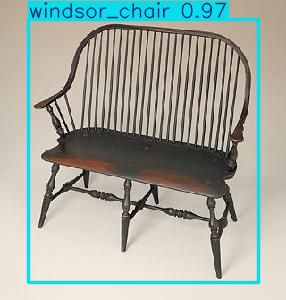

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 288, 288) BCHW and output shape(s) (1, 6, 1701) (5.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 231.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 352.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 187.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 147.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 201.0 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 24.7s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slim

In [19]:
#{'alexnet': 0,'vgg': 1,'resnet': 2,'unet':3,'yolo':4,'propi':5}

if MODEL == architectures['unet']:
  prova()
  visualitza_resultats() #visualitza les màsqueres previstes
elif MODEL != architectures['yolo']:
  prova()
else: #yolo
  train_results = model.train(
      data="/content/data.yaml",
      epochs=100,
      imgsz=288,
      verbose=True
  )

  metrics = model.val()

  results = model(X_test[0])
  results[0].show()


  path = model.export(format="onnx")

In [20]:
i = 32
mat_data = scipy.io.loadmat(annotations_train[i])
#print(mat_data)
boundingbox_data = mat_data['box_coord']
print(mat_data['box_coord'])
dimensions = Image.open(X_train[i]).size

# print(boundingbox_data)
# print(dimensions)

[[  2 299   2 183]]


In [21]:
print(training.__getdist__())

1    90
0    74
Name: count, dtype: int64
